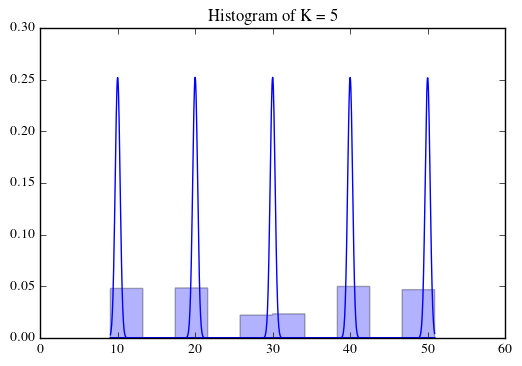

In [22]:
# Simulates non-random 1D distribution of stars

import gfc
from gfc import *
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'serif', 'serif':['Times']})
rc('text', usetex=True)

from astropy.table import Table
from astropy import units as u
from astropy.coordinates import Angle

import copy as cp
import pygaia.astrometry.vectorastrometry as pg
import numpy as np
import scipy as sp

"""
Set number of components and number of stars here
"""
K = 5
N = 1000

wmin=.5
wmax=5
wstep=.25
Kmin=1
Kmax=10
Kstep=1

"""
Data simulation
"""
init_amps = np.empty([10,10])
for i in xrange(10):
    amp = np.tile([1./(i+1)], i+1)
    rest = np.tile(0, 9-i)
    init_amps[i] = np.append(amp, rest)

init_means = np.array([[10.], [20.], [30.], [40.], [50.], [60.], [70.], [80.], [90.], [100.]])
init_covs = np.array([[[0.1]], [[0.1]], [[0.1]], [[0.1]], [[0.1]], [[0.1]], [[0.1]], [[0.1]], [[0.1]], [[0.1]]])

comp = np.random.choice(K, N, p=init_amps[K-1][:K])

d = np.empty([N,1])
dcov = np.empty([N,1])
for n in xrange(N):
    d[n,0] = np.random.multivariate_normal(init_means[comp[n]], init_covs[comp[n]])
    dcov[n,0] = init_covs[comp[n]]

"""
Make histogram of data
"""
x = np.linspace(np.amin(d), np.amax(d), N)
for k in range(K):
    plt.plot(x, init_amps[K-1][k]*sp.stats.norm.pdf(x, loc=init_means[k,0], scale=np.sqrt(init_covs[k,0,0])), color='blue', lw=1)
plt.title("Histogram of K = {0}".format(K))
plt.hist(d, facecolor='blue', normed=True, histtype='stepfilled', alpha=.3)
plt.show()

In [68]:
# Find log likelihood with XD and find AIC and find MDL for different values of K (same w)
dim = 3.

Krange = range(Kmin, Kmax + Kstep, Kstep)

logL_K = np.tile(np.nan, (len(Krange)))
AIC_K = np.tile(np.nan, (len(Krange)))
MDL_K = np.tile(np.nan, (len(Krange)))

for k in Krange:
    input_amps = cp.copy(init_amps)
    input_means = cp.copy(init_means)
    input_covs = cp.copy(init_covs)
    amps_xd, means_xd, covs_xd, logL_K[k-1] = XD(d, dcov, input_amps[k-1][:k], input_means[:k], input_covs[:k]) #extreme deconvolution
    logL_K[k-1] *= N
    AIC_K[k-1] = -2./N*(N-1.-dim-Kmax/2.)*logL_K[k-1]+3*k*dim
    MDL_K[k-1] = -logL_K[k-1] + k*dim*np.log(N)/2.

#print "logL", logL_K
#print "AIC", AIC_K
#print "MDL", MDL_K

bestK_logL_K = Krange[np.unravel_index(np.nanargmax(logL_K), logL_K.shape)[0]]
print "logL: best K =", bestK_logL_K

bestK_AIC_K = Krange[np.unravel_index(np.nanargmin(AIC_K), AIC_K.shape)[0]]
print "AIC: best K =", bestK_AIC_K

bestK_MDL_K = Krange[np.unravel_index(np.nanargmin(MDL_K), MDL_K.shape)[0]]
print "MDL: best K =", bestK_MDL_K

logL: best K = 10
AIC: best K = 5
MDL: best K = 5


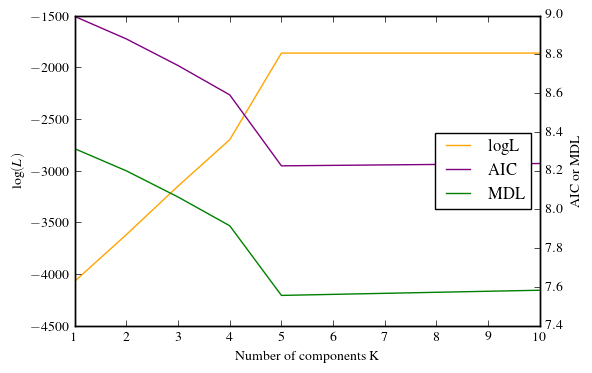

In [70]:
# Plot log likelihood and AIC for different K

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.set_xlabel("Number of components K")
ax1.set_ylabel("$\log(L)$") ; ax2.set_ylabel("AIC or MDL")
lns1 = ax1.plot(Krange, logL_K, color='orange', label="logL")
lns2 = ax2.plot(Krange, np.log(AIC_K), color='purple', label="AIC")
lns3 = ax2.plot(Krange, np.log(MDL_K), color='green', label="MDL")
lns = lns1 + lns2 + lns3
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc='center right')

plt.show()

In [71]:
# Find loglikelihood with XD and find AIC for different values of K and different values of w

wrange = np.arange(wmin, wmax + wstep, wstep)**2.
Krange = range(Kmin, Kmax + Kstep, Kstep)

logL_Kw = np.tile(np.nan, (len(Krange), len(wrange)))
AIC_Kw = np.tile(np.nan, (len(Krange), len(wrange)))
MDL_Kw = np.tile(np.nan, (len(Krange), len(wrange)))

for k in Krange:
    for W in xrange(len(wrange)):
        input_amps = cp.copy(init_amps)
        input_means = cp.copy(init_means)
        input_covs = cp.copy(init_covs)
        amps_xd, means_xd, covs_xd, logL_Kw[k-1,W] = XD(d, dcov, input_amps[k-1][:k], input_means[:k], input_covs[:k], w=wrange[W]) #extreme deconvolution
        logL_Kw[k-1,W] *= N
        AIC_Kw[k-1,W] = -2./N*(N-1.-dim-Kmax/2.)*logL_Kw[k-1,W]+3*k*dim
        MDL_Kw[k-1,W] = -logL_Kw[k-1,W] + k*dim*np.log(N)/2.
        
best_logL_Kw = np.unravel_index(np.nanargmax(logL_Kw), logL_Kw.shape)
bestK_logL_Kw = Krange[best_logL_Kw[0]] ; bestw_logL_Kw = wrange[best_logL_Kw[1]]
print "logL: best K = {K} ; best w = {w}".format(K = bestK_logL_Kw, w = bestw_logL_Kw)

best_AIC_Kw = np.unravel_index(np.nanargmin(AIC_Kw), AIC_Kw.shape)
bestK_AIC_Kw = Krange[best_AIC_Kw[0]] ; bestw_AIC_Kw = wrange[best_AIC_Kw[1]]
print "AIC: best K = {K} ; best w = {w}".format(K = bestK_AIC_Kw, w = bestw_AIC_Kw)

best_MDL_Kw = np.unravel_index(np.nanargmin(MDL_Kw), MDL_Kw.shape)
bestK_MDL_Kw = Krange[best_MDL_Kw[0]] ; bestw_MDL_Kw = wrange[best_MDL_Kw[1]]
print "MDL: best K = {K} ; best w = {w}".format(K = bestK_MDL_Kw, w = bestw_MDL_Kw)

logL: best K = 7 ; best w = 0.25
AIC: best K = 5 ; best w = 0.25
MDL: best K = 5 ; best w = 0.25


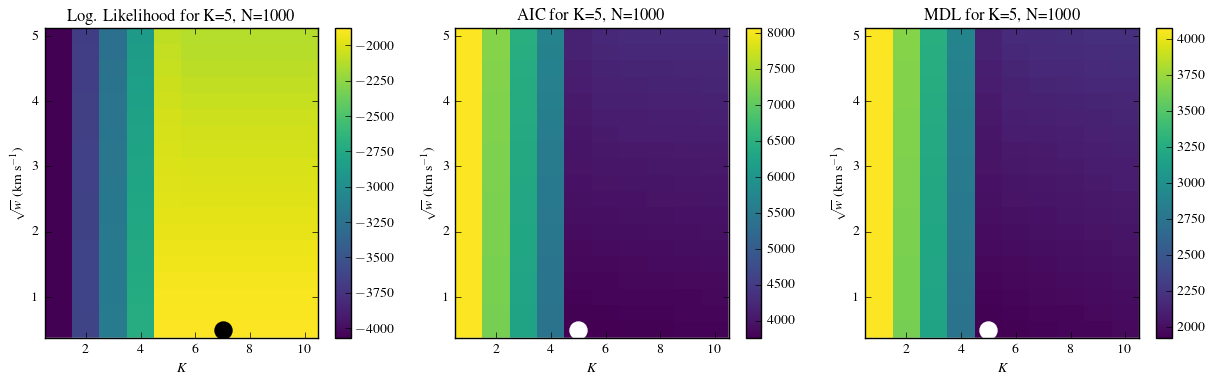

In [73]:
# Plot log likelihood and AIC for different K and w

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,4))
ax1.set_xlabel("$K$") ; ax2.set_xlabel("$K$") ; ax3.set_xlabel("$K$")
ax1.set_ylabel("$\sqrt{w}$ (km s$^{-1}$)") ; ax2.set_ylabel("$\sqrt{w}$ (km s$^{-1}$)") ; ax3.set_ylabel("$\sqrt{w}$ (km s$^{-1}$)")
ax1.set_xlim(Kmin-.5, Kmax+.5) ; ax2.set_xlim(Kmin-.5, Kmax+.5) ; ax3.set_xlim(Kmin-.5, Kmax+.5)
ax1.set_ylim(wmin-.125, wmax+.125) ; ax2.set_ylim(wmin-.125, wmax+.125) ; ax3.set_ylim(wmin-.125, wmax+.125)

ax1.set_title("Log. Likelihood for K={0}, N={1}".format(K, N))
ax1.scatter(bestK_logL_Kw, np.sqrt(bestw_logL_Kw), color="black", marker="o", s=150)
im1 = ax1.imshow(logL_Kw.T, cmap=plt.cm.viridis, extent=(Kmin-.5, Kmax+.5, wmin-.125, wmax+.125), aspect='auto', interpolation='none', origin="lower")
cbar1 = fig.colorbar(im1, ax=ax1, orientation="vertical")

ax2.set_title("AIC for K={0}, N={1}".format(K, N))
ax2.scatter(bestK_AIC_Kw, np.sqrt(bestw_AIC_Kw), color="white", marker="o", s=150)
im2 = ax2.imshow(AIC_Kw.T, cmap=plt.cm.viridis, extent=(Kmin-.5, Kmax+.5, wmin-.125, wmax+.125), aspect='auto', interpolation='none', origin="lower")
cbar2 = fig.colorbar(im2, ax=ax2, orientation="vertical")

ax3.set_title("MDL for K={0}, N={1}".format(K, N))
ax3.scatter(bestK_MDL_Kw, np.sqrt(bestw_MDL_Kw), color="white", marker="o", s=150)
im3 = ax3.imshow(MDL_Kw.T, cmap=plt.cm.viridis, extent=(Kmin-.5, Kmax+.5, wmin-.125, wmax+.125), aspect='auto', interpolation='none', origin="lower")
cbar3 = fig.colorbar(im3, ax=ax3, orientation="vertical")

plt.show()